In [74]:
######## MODULES ##########
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celia_functions as cf
from scipy import optimize as spopt
plt.rcParams.update({'font.size':28, "xtick.direction":"in", "ytick.direction":"in", "xtick.top": True, "ytick.right": True, "figure.figsize": [12, 8]})
pd.set_option('display.max_rows', 50)
#np.set_printoptions(threshold=sys.maxsize)

In [75]:
shotsheet = cf.read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel","Thickness (um)","Length(mm)","Material","Type"])

shotsheet = pd.DataFrame(shotsheet)
targetsheet = pd.DataFrame(targetsheet)

to_numeric = lambda series: pd.to_numeric(series, errors= "coerce") # pd.to_numeric works on pd.series but not on pd.DataFrames
shotsheet = shotsheet.apply(to_numeric) 
shotsheet.dropna(how= "all", inplace= True) # last row has no data! Remove it.

shotsheet = shotsheet.merge(targetsheet, how= "left", left_on= "TARGET NUMBER", right_on= "Number") # merge the targetsheet with the shotsheet
shotsheet.drop("Number", axis= 1, inplace= True)

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,Thickness (um),Length(mm)
count,266.000000,234.000000,234.000000,266.000000,201.000000,266.000000,266.000000,266.000000
mean,132.661654,3.552863,6.181303,68.000000,0.884909,4.409774,264.097744,8.300752
std,76.697139,1.382375,0.950730,37.500893,0.173772,1.806001,397.911451,1.228498
min,1.000000,0.705000,3.195000,1.000000,0.091800,1.000000,25.000000,4.000000
25%,66.250000,2.475000,5.590000,33.750000,0.827000,3.000000,50.000000,8.000000
50%,132.500000,3.395000,6.170000,69.000000,0.873000,4.000000,50.000000,8.000000
75%,198.750000,4.511250,6.790000,104.750000,0.953000,6.000000,50.000000,8.000000
max,265.000000,6.985000,8.815000,125.000000,1.800000,7.000000,1000.000000,10.000000


In [76]:
shotsheet["relative X"] = shotsheet.groupby('TARGET NUMBER')['Target X'].transform(lambda x: x -x.iloc[0]) #calculate the relitive movement from the first shot.
shotsheet["relative Z"] = shotsheet.groupby('TARGET NUMBER')['Target Z'].transform(lambda x: x -x.iloc[0])
shotsheet["nth shot on target"] = shotsheet.groupby('TARGET NUMBER')["TARGET NUMBER"].transform(lambda series: np.arange(len(series)) +1) #add a column that counts how many times the target has been shot.

shotsheet["d"] = np.linalg.norm(shotsheet[["relative X", "relative Z"]], axis= 1) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

# Apply filters
shotsheet = shotsheet[shotsheet["Type"] == "wire"]
shotsheet = shotsheet[shotsheet["Material"] == "Cu"]
shotsheet = shotsheet[shotsheet["Length(mm)"] == 8]

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d
count,158.000000,153.000000,153.000000,158.000000,150.000000,158.000000,158.0,158.0,153.000000,153.000000,158.000000,153.000000
mean,151.860759,3.139706,5.933497,81.936709,0.859880,4.974684,50.0,8.0,1.181111,0.696209,4.050633,1.397450
std,60.580574,1.041783,0.844642,25.858183,0.112956,1.286626,0.0,0.0,0.983230,0.589355,2.793982,1.113761
min,34.000000,0.795000,3.195000,16.000000,0.414000,2.000000,50.0,8.0,0.000000,0.000000,1.000000,0.000000
25%,101.250000,2.375000,5.400000,60.000000,0.809500,4.000000,50.0,8.0,0.380000,0.220000,2.000000,0.466476
50%,140.500000,3.035000,5.960000,81.000000,0.862500,5.000000,50.0,8.0,1.000000,0.610000,4.000000,1.337199
75%,199.750000,3.905000,6.470000,107.000000,0.933500,6.000000,50.0,8.0,1.900000,1.115000,6.000000,2.263537
max,258.000000,5.495000,8.455000,116.000000,1.080000,7.000000,50.0,8.0,3.500000,2.585000,15.000000,3.908657


### Choose which targets and channels to use here!

In [77]:
pyro_background = {"Ch1": [99,100,101,102,104,105,107,108,109,110,111,112,113,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,214,215,216,217,218,219,220,221,222,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
                   "Ch2": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153],
                   "Ch3": [70,71,72,74,75,76,77,78,79,80,83,84,85,86,87,88,89,92,93,94,95,96,97,98]}

diagnostics = {"Ch1": shotsheet["SHOT #"],
               "Ch2": [156,157,209,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
               "Ch3": [114,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137],
               "Ch4": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,147,148,149,150,151,158,159,160,161,162,163,164,165,166],
               "bdot": shotsheet["SHOT #"],
               "xray": [114,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,156,157,209,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
               "energy": [114,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,156,157,209,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265]}

diagnostics_functions = {"Ch1": lambda x: x,
                         "Ch2": lambda x: x,
                         "Ch3": lambda x: x,
                         "Ch4": lambda x: x,
                         "bdot": lambda x: np.ma.masked_invalid(x).ptp(),
                         "tof": np.ptp,
                         "diode": np.ptp,
                         "xray": cf.estimate_xray_signal,
                         "energy": lambda x: x}

diagnostic_data = cf.read_diagnostic_data(diagnostics, functions= diagnostics_functions, silent= False)
diagnostic_data = pd.DataFrame(diagnostic_data)

background_data = cf.read_diagnostic_data(pyro_background, functions= diagnostics_functions, silent= False)
background_data = pd.DataFrame(background_data)

background_lookup = pd.DataFrame(([shot, ch, cf.flatten_list(background_data[ch][background_data["shot"] == shot].values)] for ch, shots in pyro_background.items() for shot in shots), columns= ["shot", "bg channel", "bg data"]) #Create a dataframe with the bg data

Found 149 files:
   260124WIRESHOT70000_Ch1.csv
   260124WIRESHOT70001_Ch1.csv
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT72000_Ch1.csv
   260124WIRESHOT74000_Ch1.csv
   260124WIRESHOT75000_Ch1.csv
   290124WIRESHOT76000_Ch1.csv
   290124WIRESHOT77000_Ch1.csv
   290124WIRESHOT78000_Ch1.csv
   290124WIRESHOT79000_Ch1.csv
   290124WIRESHOT80000_Ch1.csv
   290124WIRESHOT81000_Ch1.csv
   290124WIRESHOT82000_Ch1.csv
   290124WIRESHOT83000_Ch1.csv
   290124WIRESHOT84000_Ch1.csv
   290124WIRESHOT85000_Ch1.csv
   290124WIRESHOT86000_Ch1.csv
   290124WIRESHOT87000_Ch1.csv
   290124WIRESHOT88000_Ch1.csv
   290124WIRESHOT89000_Ch1.csv
   290124WIRESHOT91000_Ch1.csv
   290124WIRESHOT92000_Ch1.csv
   290124WIRESHOT93000_Ch1.csv
   290124WIRESHOT94000_Ch1.csv
   290124WIRESHOT95000_Ch1.csv
   290124WIRESHOT96000_Ch1.csv
   290124WIRESHOT97000_Ch1.csv
   290124WIRESHOT98000_Ch1.csv
   290124WIRESHOT100000_Ch1.csv
   290124WIRESHOT101000_Ch1.csv
   290124WIRESHOT102000_Ch1.csv
   290124WIRESHOT10

In [78]:
pyro_channels_to_bg_subtract = ["Ch1","Ch2","Ch3"]
pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys())) # useful to know which pyro channels to analysise and plot
pyro_channels_to_bg_subtract = np.intersect1d(pyro_channels_to_bg_subtract, list(diagnostic_data.keys())) 

diagnostic_data = diagnostic_data.merge(background_lookup, how= "left", on= "shot") # add the background infomation to the shotsheet
diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured

C:\Users\syf83691\AppData\Local\Temp\ipykernel_15172\2945668715.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured


In [79]:
for ch in pyro_channels_to_bg_subtract:
    diagnostic_data[ch] = diagnostic_data[ch] -diagnostic_data["bg data"]

diagnostic_data.drop("bg data", axis= 1, inplace= True) # The background data is no longer needed now that we have finished background subtraction.

diagnostic_data.describe()

,shot,bdot,xray,energy
count,173.000000,147.000000,25.000000,4.200000e+01
mean,161.387283,0.622653,953.700000,1.159190e-06
std,60.097452,0.193650,314.235083,3.785531e-07
min,34.000000,0.021836,200.000000,2.100000e-07
25%,111.000000,0.525398,807.000000,9.947500e-07
50%,156.000000,0.655547,861.000000,1.190000e-06
75%,209.000000,0.754352,1019.500000,1.365000e-06
max,265.000000,1.010719,1548.000000,2.040000e-06


In [80]:
find_minima = lambda x: np.abs(np.nanmin(x))
diagnostic_data[pyro_channels] = diagnostic_data[pyro_channels].map(find_minima, na_action= "ignore") # find the minima of every pyro channel. df.map applies the function element-wise rather than row or column-wise

shotsheet = shotsheet.merge(diagnostic_data, how= "left", left_on= "SHOT #", right_on= "shot") #merge with shotsheet
shotsheet.drop("shot", axis= 1, inplace= True)

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy
count,158.000000,153.000000,153.000000,158.000000,150.000000,158.000000,158.0,158.0,153.000000,153.000000,158.000000,153.000000,146.000000,9.000000,23.000000,37.000000,147.000000,23.000000,3.000000e+01
mean,151.860759,3.139706,5.933497,81.936709,0.859880,4.974684,50.0,8.0,1.181111,0.696209,4.050633,1.397450,0.150192,5.184000,4.026957,0.306054,0.622653,938.000000,1.251500e-06
std,60.580574,1.041783,0.844642,25.858183,0.112956,1.286626,0.0,0.0,0.983230,0.589355,2.793982,1.113761,0.297290,2.072942,1.595113,0.106661,0.193650,312.588278,3.242103e-07
min,34.000000,0.795000,3.195000,16.000000,0.414000,2.000000,50.0,8.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.600000,1.800000,0.160000,0.021836,200.000000,2.100000e-07
25%,101.250000,2.375000,5.400000,60.000000,0.809500,4.000000,50.0,8.0,0.380000,0.220000,2.000000,0.466476,0.000000,4.048000,2.910000,0.216000,0.525398,803.500000,1.112500e-06
50%,140.500000,3.035000,5.960000,81.000000,0.862500,5.000000,50.0,8.0,1.000000,0.610000,4.000000,1.337199,0.000000,5.600000,3.520000,0.264000,0.655547,853.500000,1.260000e-06
75%,199.750000,3.905000,6.470000,107.000000,0.933500,6.000000,50.0,8.0,1.900000,1.115000,6.000000,2.263537,0.155000,5.872000,4.920000,0.400000,0.754352,1017.250000,1.390000e-06
max,258.000000,5.495000,8.455000,116.000000,1.080000,7.000000,50.0,8.0,3.500000,2.585000,15.000000,3.908657,1.608000,7.792000,8.020000,0.616000,1.010719,1548.000000,2.040000e-06


In [81]:
diags = list(diagnostics)

#shotsheet[diags] = (shotsheet[diags].values.T /shotsheet["Laser Energy (before comp) [J]"].values).T # normalise for laser energy
#shotsheet[diags] = shotsheet.groupby('TARGET NUMBER')[diags].transform(lambda x: x /x.iloc[0]) # normalise to first shot on target
#shotsheet[diags] = shotsheet[diags] /shotsheet[diags].mean() #normalise to mean
shotsheet = shotsheet.replace([-np.inf, np.inf], np.nan) # infs are invalid. I think there were some div 0 errors when normalising to the first shot on target.

shotsheet.describe()

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy
count,158.000000,153.000000,153.000000,158.000000,150.000000,158.000000,158.0,158.0,153.000000,153.000000,158.000000,153.000000,146.000000,9.000000,23.000000,37.000000,147.000000,23.000000,3.000000e+01
mean,151.860759,3.139706,5.933497,81.936709,0.859880,4.974684,50.0,8.0,1.181111,0.696209,4.050633,1.397450,0.150192,5.184000,4.026957,0.306054,0.622653,938.000000,1.251500e-06
std,60.580574,1.041783,0.844642,25.858183,0.112956,1.286626,0.0,0.0,0.983230,0.589355,2.793982,1.113761,0.297290,2.072942,1.595113,0.106661,0.193650,312.588278,3.242103e-07
min,34.000000,0.795000,3.195000,16.000000,0.414000,2.000000,50.0,8.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.600000,1.800000,0.160000,0.021836,200.000000,2.100000e-07
25%,101.250000,2.375000,5.400000,60.000000,0.809500,4.000000,50.0,8.0,0.380000,0.220000,2.000000,0.466476,0.000000,4.048000,2.910000,0.216000,0.525398,803.500000,1.112500e-06
50%,140.500000,3.035000,5.960000,81.000000,0.862500,5.000000,50.0,8.0,1.000000,0.610000,4.000000,1.337199,0.000000,5.600000,3.520000,0.264000,0.655547,853.500000,1.260000e-06
75%,199.750000,3.905000,6.470000,107.000000,0.933500,6.000000,50.0,8.0,1.900000,1.115000,6.000000,2.263537,0.155000,5.872000,4.920000,0.400000,0.754352,1017.250000,1.390000e-06
max,258.000000,5.495000,8.455000,116.000000,1.080000,7.000000,50.0,8.0,3.500000,2.585000,15.000000,3.908657,1.608000,7.792000,8.020000,0.616000,1.010719,1548.000000,2.040000e-06


In [82]:
shotsheet["target desc"] = ["{0:.0f}mm {1:} {2:}".format(length, material, ttype)
                            for length, material, ttype
                            in zip(shotsheet["Length(mm)"], shotsheet["Material"], shotsheet["Type"])]

shotsheet["target desc"].unique() #The target description combines the length, material and type of target.

array(['8mm Cu wire'], dtype=object)

### Setup parameters for graph

In [83]:
shotsheet.columns

Index(['SHOT #', 'Target X', 'Target Z', 'TARGET NUMBER',
       'Laser Energy (before comp) [J]', 'Wheel', 'Thickness (um)',
       'Length(mm)', 'Material', 'Type', 'relative X', 'relative Z',
       'nth shot on target', 'd', 'Ch1', 'Ch2', 'Ch3', 'Ch4', 'bdot', 'xray',
       'energy', 'bg channel', 'target desc'],
      dtype='object')

In [93]:
xaxis = "energy"

yaxis = ["energy"]

def line(x, m, c):
    return m*x +c

xdata = 8-shotsheet[xaxis]
xdata= np.ravel(xdata)
ydata = shotsheet[yaxis]
ydata = np.ravel(ydata)
is_valid = ~np.logical_or(np.isnan(xdata), np.isnan(ydata))

popt, pcov = spopt.curve_fit(line, xdata[is_valid], ydata[is_valid], method= "trf", loss= "linear") #scipy curvefit only raises an error if the y data has nans. It doesn't check the x data.

x = np.linspace(np.min(xdata[is_valid]), np.max(xdata[is_valid]), 100)

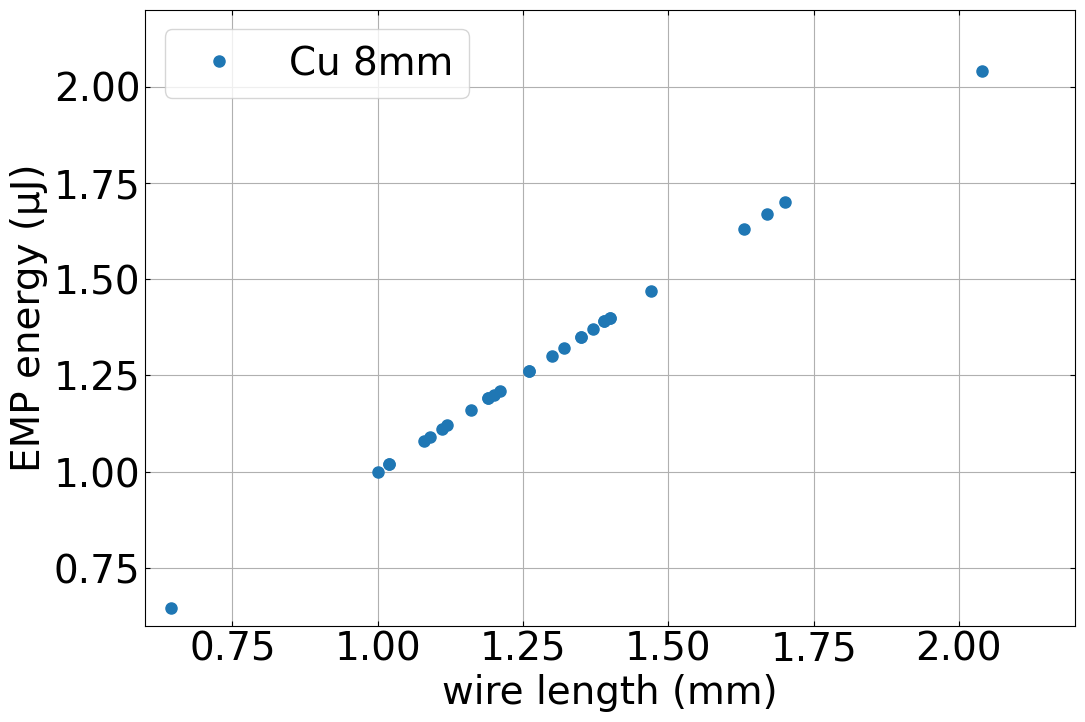

In [96]:
fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shotsheet[xaxis]*1e6, shotsheet[yaxis]*1e6, color= "tab:blue", marker= "o", markersize= 8, linestyle= "None", label= "Cu 8mm")
axs.plot(x, line(x, *popt)*1e6, color= "tab:blue")

axs.set(xlabel= "wire length (mm)", ylabel= "EMP energy (μJ)", ylim= (0.6, 2.2), xlim= (0.6, 2.2))
axs.grid()
axs.legend()

plt.show()

In [117]:
yaxis = ["Ch2", "Ch3"]

def line(x, m, c):
    return m*x +c

xdata = 8-shotsheet[xaxis]
xdata= np.repeat(xdata, len(yaxis))
ydata = shotsheet[yaxis]
ydata = np.ravel(ydata)
is_valid = ~np.logical_or(np.isnan(xdata), np.isnan(ydata))

popt, pcov = spopt.curve_fit(line, xdata[is_valid], ydata[is_valid], method= "trf", loss= "linear") #scipy curvefit only raises an error if the y data has nans. It doesn't check the x data.

x = np.linspace(np.min(xdata[is_valid]), np.max(xdata[is_valid]), 100)

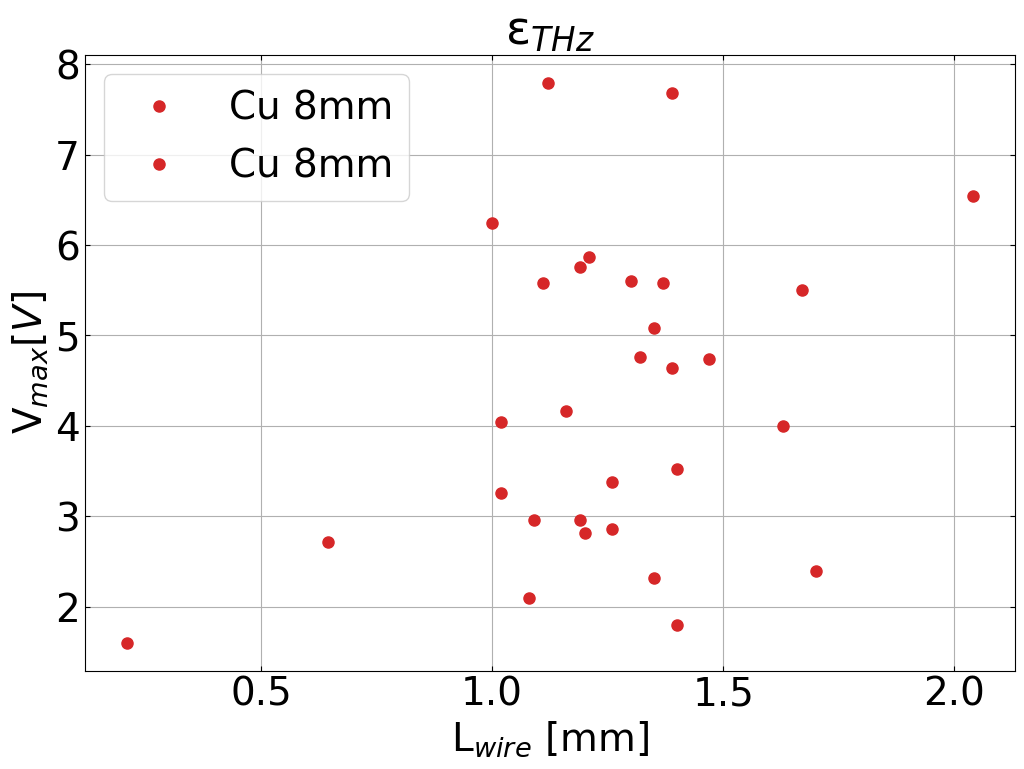

In [118]:
fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shotsheet[xaxis]*1e6, shotsheet[yaxis], color= "tab:red", marker= "o", markersize= 8, linestyle= "None", label= "Cu 8mm")
#axs.plot(x, line(x, *popt), color= "tab:red")

axs.set(xlabel= "L$_{wire}$ [mm]", ylabel= "V$_{max} [V]$", title= "ε$_{THz}$")
axs.grid()
axs.legend()

plt.show()

In [114]:
yaxis = ["xray"]

def line(x, m, c):
    return m*x +c

xdata = 8-shotsheet[xaxis]
xdata = np.ravel(xdata)
ydata = shotsheet[yaxis]
ydata = np.ravel(ydata)
is_valid = ~np.logical_or(np.isnan(xdata), np.isnan(ydata))

popt, pcov = spopt.curve_fit(line, xdata[is_valid], ydata[is_valid], method= "trf", loss= "linear") #scipy curvefit only raises an error if the y data has nans. It doesn't check the x data.

x = np.linspace(np.min(xdata[is_valid]), np.max(xdata[is_valid]), 100)

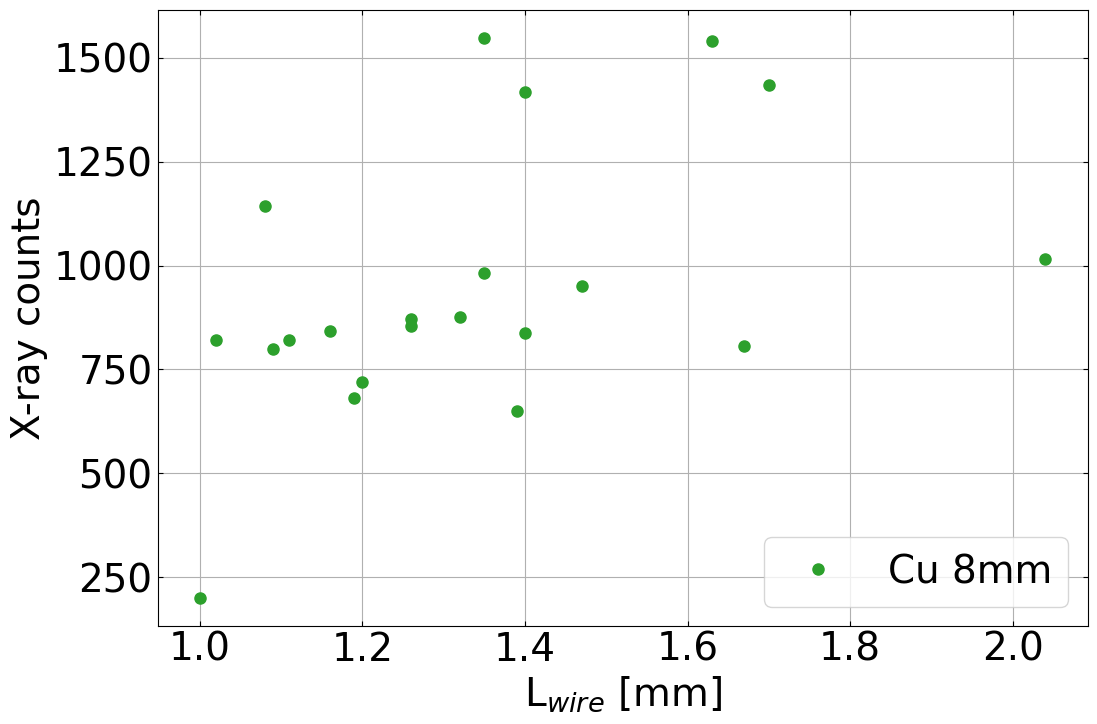

In [116]:
fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shotsheet[xaxis] *1e6, shotsheet[yaxis], color= "tab:green", marker= "o", markersize= 8, linestyle= "None", label= "Cu 8mm")
#axs.plot(x, line(x, *popt), color= "tab:green")

axs.set(xlabel= "L$_{wire}$ [mm]", ylabel= "X-ray counts")
axs.grid()
axs.legend()

plt.show()